# yolov3實作

教學資源:
1. [wizyoung/YOLOv3_TensorFlow](https://github.com/wizyoung/YOLOv3_TensorFlow)
    * https://www.jishuwen.com/d/2LQY/zh-tw
2. [qqwweee/keras-yolo3](https://github.com/qqwweee/keras-yolo3)：我用的
    * [CSDN_動手train yolo模型](https://my.oschina.net/u/876354/blog/1927881?p=3)
    * https://blog.csdn.net/zong596568821xp/article/details/86467456
3. [mystic123/tensorflow-yolo-v3](https://github.com/mystic123/tensorflow-yolo-v3)
    * https://blog.csdn.net/haoqimao_hard/article/details/88863744
4. [pjreddie/darknet](https://github.com/pjreddie/darknet)
5. [如何以YOLOv3訓練自己的資料集 ─ 以小蕃茄為例](https://makerpro.cc/2019/12/train-your-dataset-with-yolov3/)
6. [作者個人網站](https://pjreddie.com/darknet/yolo/)
7. [建立自己的YOLO辨識模型 – 以柑橘辨識為例](https://chtseng.wordpress.com/2018/09/01/%E5%BB%BA%E7%AB%8B%E8%87%AA%E5%B7%B1%E7%9A%84yolo%E8%BE%A8%E8%AD%98%E6%A8%A1%E5%9E%8B-%E4%BB%A5%E6%9F%91%E6%A9%98%E8%BE%A8%E8%AD%98%E7%82%BA%E4%BE%8B/)：蠻詳細的
8. [車牌dataset下載來源](https://medium.com/@theophilebuyssens/license-plate-recognition-using-opencv-yolo-and-keras-f5bfe03afc65)

論文:
1. [YOLOv3: An Incremental Improvement](https://pjreddie.com/media/files/papers/YOLOv3.pdf)

其他:
1. [R-CNN、Fast R-CNN、Faster R-CNN、YOLO、SSD](https://kknews.cc/zh-tw/code/k2yqmvb.html)
2. [Object Detection : R-CNN, Fast-RCNN, Faster RCNN](https://medium.com/@ccshenyltw/object-detection-r-cnn-fast-rcnn-faster-rcnn-mask-rcnn-retinanet-to-be-continued-71b67640445)

# 簡介
影像分類、物件偵測、像素級物件影像分割（語義分割及實例分割）

    two-stage: R-CNN、Fast R-CNN、Faster R-CNN
    one-stage: YOLO、SSD、R-FCN

# 實作過程

## 環境
1. Tensorflow-gpu == 1.6.0
2. Keras-gpu == 2.1.5
3. python == 3.6
4. cuda 9.0.176
5. cudnn 7.0.5
6. pretrained weights
    * [darknet53.conv](https://pjreddie.com/media/files/darknet53.conv.74)
    * [yolov3.weights](https://pjreddie.com/media/files/yolov3.weights)：我用這個

## 建立資料集
    1. 拍攝圖片
    2. 拍攝影片
    3. 現成資料庫

## 標註資料集(LabelImg)
1. [LabelImg](https://github.com/tzutalin/labelImg)
2. [CSDN](https://my.oschina.net/u/876354/blog/1927351)

    採用 VOC2007 的物件標註格式，之後再透過voc_annotation.py將VOC2007格式轉成YOLO格式。
    
    YOLO格式為：文件路徑, 標註框位置(左上角、右下角), 類別ID
        image_file_path x_min,y_min,x_max,y_max,class_id

## 建立類別文件
my_class.txt 內容為分類的類別

## 劃分train, val, trainval, test

[make_main_txt.py](https://github.com/EddyGao/make_VOC2007/blob/master/make_main_txt.py)

python make_main_txt.py將資料依照設定分成train, val, trainval, test

trainval = train + val

test內容不含train, val

In [ ]:
# make_main_txt.py
import os
import random

trainval_percent = 0.66
train_percent = 0.5
path= 'D:\\keras-yolo3-qqwweee\\VOCdevkit\\VOC2007\\'
xmlfilepath = path + 'Annotations'
txtsavepath = path + 'ImageSets/Main'
total_xml = os.listdir(xmlfilepath)

num=len(total_xml)
list=range(num)
tv=int(num*trainval_percent)
tr=int(tv*train_percent)
trainval= random.sample(list,tv)
train=random.sample(trainval,tr)

ftrainval = open(path+'ImageSets/Main/trainval.txt', 'w')
ftest = open(path+'ImageSets/Main/test.txt', 'w')
ftrain = open(path+'ImageSets/Main/train.txt', 'w')
fval = open(path+'ImageSets/Main/val.txt', 'w')

for i  in list:
    name=total_xml[i][:-4]+'\n'
    if i in trainval:
        ftrainval.write(name)
        if i in train:
            ftrain.write(name)
        else:
            fval.write(name)
    else:
        ftest.write(name)

ftrainval.close()
ftrain.close()
fval.close()
ftest .close()

## 轉換pretrained weights為h5
    轉換pretrained weights為適合keras的模型文件h5
    python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5

## 將train, val, test.txt轉為yolo格式(VOC)
voc_annotation.py將經過make_main_txt.py得到的train, val, test轉換成yolo格式(VOC)

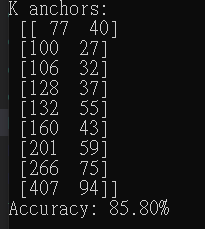

## 修改anchor文件
使用kmeans類聚得到數據集接近的anchors，將kmeans.py中的filename改為2007_train.txt(一共兩處)，運行結果返回9個anchors的座標值、準確率，將9個座標值填入model_data中的yolo_anchors.txt

In [ ]:
# kmeans.py
import numpy as np
class YOLO_Kmeans:

    def __init__(self, cluster_number, filename):
        self.cluster_number = cluster_number
        self.filename = "2007_train.txt"

    def iou(self, boxes, clusters):  # 1 box -> k clusters
        n = boxes.shape[0]
        k = self.cluster_number

        box_area = boxes[:, 0] * boxes[:, 1]
        box_area = box_area.repeat(k)
        box_area = np.reshape(box_area, (n, k))

        cluster_area = clusters[:, 0] * clusters[:, 1]
        cluster_area = np.tile(cluster_area, [1, n])
        cluster_area = np.reshape(cluster_area, (n, k))

        box_w_matrix = np.reshape(boxes[:, 0].repeat(k), (n, k))
        cluster_w_matrix = np.reshape(np.tile(clusters[:, 0], (1, n)), (n, k))
        min_w_matrix = np.minimum(cluster_w_matrix, box_w_matrix)

        box_h_matrix = np.reshape(boxes[:, 1].repeat(k), (n, k))
        cluster_h_matrix = np.reshape(np.tile(clusters[:, 1], (1, n)), (n, k))
        min_h_matrix = np.minimum(cluster_h_matrix, box_h_matrix)
        inter_area = np.multiply(min_w_matrix, min_h_matrix)

        result = inter_area / (box_area + cluster_area - inter_area)
        return result

    def avg_iou(self, boxes, clusters):
        accuracy = np.mean([np.max(self.iou(boxes, clusters), axis=1)])
        return accuracy

    def kmeans(self, boxes, k, dist=np.median):
        box_number = boxes.shape[0]
        distances = np.empty((box_number, k))
        last_nearest = np.zeros((box_number,))
        np.random.seed()
        clusters = boxes[np.random.choice(
            box_number, k, replace=False)]  # init k clusters
        while True:

            distances = 1 - self.iou(boxes, clusters)

            current_nearest = np.argmin(distances, axis=1)
            if (last_nearest == current_nearest).all():
                break  # clusters won't change
            for cluster in range(k):
                clusters[cluster] = dist(  # update clusters
                    boxes[current_nearest == cluster], axis=0)

            last_nearest = current_nearest

        return clusters

    def result2txt(self, data):
        f = open("yolo_anchors.txt", 'w')
        row = np.shape(data)[0]
        for i in range(row):
            if i == 0:
                x_y = "%d,%d" % (data[i][0], data[i][1])
            else:
                x_y = ", %d,%d" % (data[i][0], data[i][1])
            f.write(x_y)
        f.close()

    def txt2boxes(self):
        f = open(self.filename, 'r')
        dataSet = []
        for line in f:
            infos = line.split(" ")
            length = len(infos)
            for i in range(1, length):
                width = int(infos[i].split(",")[2]) - \
                    int(infos[i].split(",")[0])
                height = int(infos[i].split(",")[3]) - \
                    int(infos[i].split(",")[1])
                dataSet.append([width, height])
        result = np.array(dataSet)
        f.close()
        return result

    def txt2clusters(self):
        all_boxes = self.txt2boxes()
        result = self.kmeans(all_boxes, k=self.cluster_number)
        result = result[np.lexsort(result.T[0, None])]
        self.result2txt(result)
        print("K anchors:\n {}".format(result))
        print("Accuracy: {:.2f}%".format(
            self.avg_iou(all_boxes, result) * 100))


if __name__ == "__main__":
    cluster_number = 9
    filename = "2007_train.txt"
    kmeans = YOLO_Kmeans(cluster_number, filename)
    kmeans.txt2clusters()

## 修改train.py
    根據個人文件位置、命名更改內容。
    annotation_path
    classes_path
    weights_path: 
    log_dir: 訓練好的h5文件位置
    
    batch_size: 每次處理時，批量處理的數量。
    
    訓練完成後，會在logs/000/文件下產生trained_weights_final.h5

In [ ]:
"""
Retrain the YOLO model for your own dataset.
"""
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

# 限制記憶體使用量
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"


def _main():

    # annotation_path、classes_path、weights_path 依照位置不同而不同
    annotation_path = '2007_train.txt'
    log_dir = 'logs/000/'
    classes_path = 'model_data/my_classes.txt'
    anchors_path = 'model_data/yolo_anchors.txt'
    class_names = get_classes(classes_path)
    num_classes = len(class_names)
    anchors = get_anchors(anchors_path)

    input_shape = (416,416) # multiple of 32, hw

    is_tiny_version = len(anchors)==6 # default setting
    if is_tiny_version:
        model = create_tiny_model(input_shape, anchors, num_classes,
            freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
    else:
        model = create_model(input_shape, anchors, num_classes,
            freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

    logging = TensorBoard(log_dir=log_dir)
    checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
        monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

    val_split = 0.1
    with open(annotation_path) as f:
        lines = f.readlines()
    np.random.seed(10101)
    np.random.shuffle(lines)
    np.random.seed(None)
    num_val = int(len(lines)*val_split)
    num_train = len(lines) - num_val

    # Train with frozen layers first, to get a stable loss.
    # Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
    if True:
        model.compile(optimizer=Adam(lr=1e-3), loss={
            # use custom yolo_loss Lambda layer.
            'yolo_loss': lambda y_true, y_pred: y_pred})

        batch_size = 3
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                steps_per_epoch=max(1, num_train//batch_size),
                validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                validation_steps=max(1, num_val//batch_size),
                epochs=50,
                initial_epoch=0,
                callbacks=[logging, checkpoint])
        model.save_weights(log_dir + 'trained_weights_stage_1.h5')

    # Unfreeze and continue training, to fine-tune.
    # Train longer if the result is not good.
    if True:
        for i in range(len(model.layers)):
            model.layers[i].trainable = True
        model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
        print('Unfreeze all of the layers.')

        batch_size = 3 # note that more GPU memory is required after unfreezing the body
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=100,
            initial_epoch=50,
            callbacks=[logging, checkpoint, reduce_lr, early_stopping])
        model.save_weights(log_dir + 'trained_weights_final.h5')

    # Further training if needed.


def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)


def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/yolo_weights.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def create_tiny_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/tiny_yolo_weights.h5'):
    '''create the training model, for Tiny YOLOv3'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16}[l], w//{0:32, 1:16}[l], \
        num_anchors//2, num_classes+5)) for l in range(2)]

    model_body = tiny_yolo_body(image_input, num_anchors//2, num_classes)
    print('Create Tiny YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze the darknet body or freeze all but 2 output layers.
            num = (20, len(model_body.layers)-2)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.7})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

if __name__ == '__main__':
    _main()

這是沒有調整anchors的train過程，Epoch = 94/100才結束模型訓練。

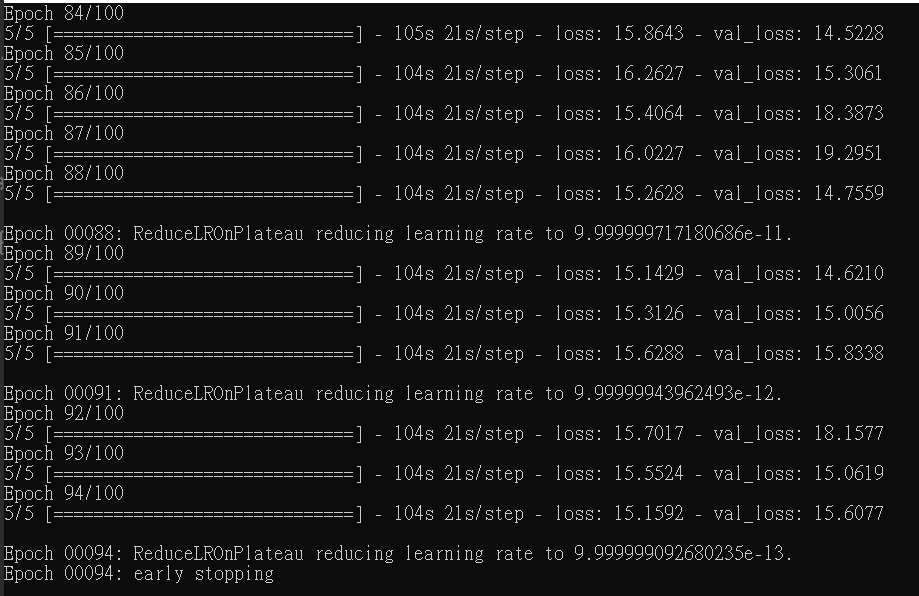

這是有調整anchors的train過程，Epoch = 77/100結束模型訓練。

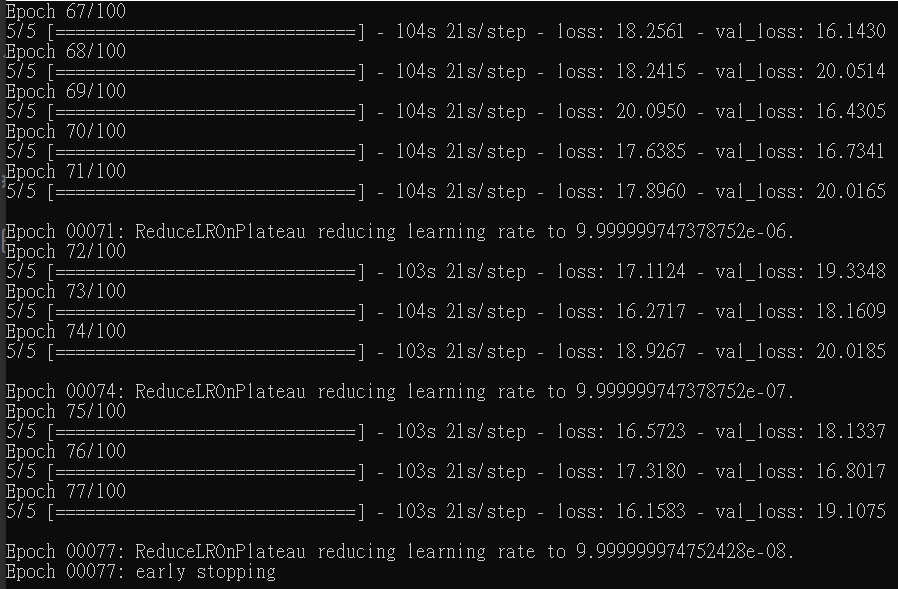

## 測試模型
    model_path: 指定 train完成權重檔路徑及名稱(trained_weights_final.h5)
    anchors_path: 錨點文件位置
    classes_path: 分類標籤文件位置
    "score" : 0.3  #最低置信度門檻(0.01~0.99)
    "iou" : 0.45   #重疊區比例(0.01~1.0)
    "model_image_size" : (416, 416)
    "gpu_num" : 1,  #使用GPU數量

In [ ]:
# yolo.py
# -*- coding: utf-8 -*-
"""
Class definition of YOLO_v3 style detection model on image and video
"""

import colorsys
import os
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
import os
from keras.utils import multi_gpu_model

# 限制記憶體使用量
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

class YOLO(object):
    _defaults = {
        "model_path": 'logs/000/trained_weights_final.h5', #指定 YOLO 訓練完成權重檔路徑及名稱
        "anchors_path": 'model_data/yolo_anchors.txt', #指定錨點定義檔路徑及名稱
        "classes_path": 'model_data/my_classes.txt', #指定自定義標籤檔路徑及名稱
        "score" : 0.3,  #最低置信度門檻(0.01~0.99)
        "iou" : 0.45,   #重疊區比例(0.01~1.0)
        "model_image_size" : (416, 416),
        "gpu_num" : 1,  #使用GPU數量
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    def detect_image(self, image):
        start = timer()

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 300

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            print(label, (left, top), (right, bottom))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw

        end = timer()
        print(end - start)
        return image

    def close_session(self):
        self.sess.close()

def detect_video(yolo, video_path, output_path=""):
    import cv2
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
    video_fps       = vid.get(cv2.CAP_PROP_FPS)
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    isOutput = True if output_path != "" else False
    if isOutput:
        print("!!! TYPE:", type(output_path), type(video_FourCC), type(video_fps), type(video_size))
        out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)
    accum_time = 0
    curr_fps = 0
    fps = "FPS: ??"
    prev_time = timer()
    while True:
        return_value, frame = vid.read()
        image = Image.fromarray(frame)
        image = yolo.detect_image(image)
        result = np.asarray(image)
        curr_time = timer()
        exec_time = curr_time - prev_time
        prev_time = curr_time
        accum_time = accum_time + exec_time
        curr_fps = curr_fps + 1
        if accum_time > 1:
            accum_time = accum_time - 1
            fps = "FPS: " + str(curr_fps)
            curr_fps = 0
        cv2.putText(result, text=fps, org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.50, color=(255, 0, 0), thickness=2)
        cv2.namedWindow("result", cv2.WINDOW_NORMAL)
        cv2.imshow("result", result)
        if isOutput:
            out.write(result)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    yolo.close_session()

if __name__ == '__main__':
    yolo=YOLO()
    path = 'D:\\keras-yolo3-qqwweee\\VOCdevkit\\VOC2007\\JPEGImages\\m25_2.jpg'
    try:
        image = Image.open(path)
    except:
        print('Open Error! Try again!')
    else:
        #r_image, _ = yolo.detect_image(image)
        r_image = yolo.detect_image(image)
        r_image.show()

    yolo.close_session()


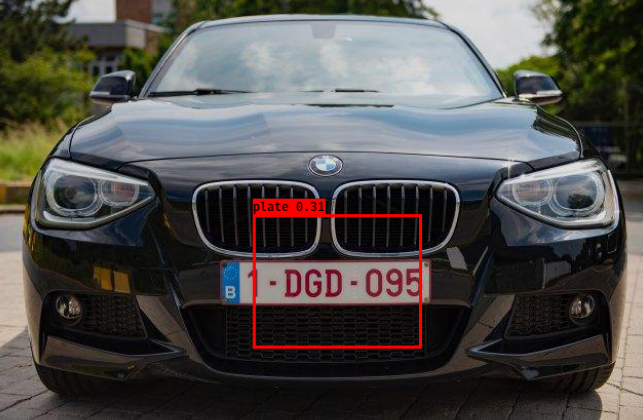

因為只訓練15張圖片，所以準確度不高，但礙於設備問題，可能再找個時間跑多一點圖片才會有更好的結果。